# Asymmetry tests

Hypothesis: the absolute value in the definition of asymmetry is **problematic**. CAS asymmetry is defined as:

$$ A = \frac{\sum |f - f^{180}|}{\sum |f| } - A_{bg}$$

where 

$$ A_{bg} = \frac{n_{obj}}{n_{sky}} \frac{\sum |f_{sky} - f_{sky}^{180}|}{\sum |f|}$$

so to expand, asymmetry is calculated as

$$ A = \frac{\sum |f - f^{180}| - \frac{n_{img}}{n_{sky}} \sum |f_{sky} - f_{sky}^{180}|}{\sum |f| } $$

This definition has a dependence on the noise, and therefore simply subtracting the background term doesn't account for all the noise in the image. The absolute value adds a correlation between the source asymmetry and the background term, even for a Gaussian background. If we used squared residuals rather than absolute residuals, this would not be a problem.

Changes to asymmetry that we test here:

1. Replace the residual calculation from absolute value to *squared*, which has a separable noise contribution
2. Add a correction term in the denominator that accounts for the contribution of BG flux to total
3. Change the initial guess for asymmetry center from center of flux to center of flux$^2$ for better performance

#### Imports

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import fits
from astropy.visualization import simple_norm
import galsim

# from asymmetry import get_asymmetry
from galaxy_generator import gen_image, gen_galaxy, petrosian_sersic, create_clumps, add_source_to_image, sky_noise
from asymmetry import get_asymmetry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams['font.size'] = 9

## Create SDSS-like image

Utility function to make an SDSS-like image using [**GalSim**](https://github.com/GalSim-developers/GalSim) and `galaxy_generator.py` functions.

Arguments:

* Basic properties
    * `mag`: source r-band magnitude
    * `r_eff`: source Sersic half-light radius in arcsec
    * `sky_mag`: sky surface brightness in mag/arcsec$^2$. Typical for SDSS r-band: 24.4
    * `psf_fwhm`: seeing in arcseconds (typical for SDSS *r*: 1.32)
    * `fov_reff`: field of view in units of the effective radius
* Source properties
    * `sersic_n`: Sersic index 
    * `q`: Axis ratio
    * `beta`: Orientation angle
* Asymmetric feature properties
    * `n_clumps`: number of asymmetric clumps to add to the image

**<font color='#aa33ff'>Questions:</font>**

1. Where do the telescope and transmission parameters come from?
2. What is the relevance of centre ra and dec?
3. What is 1 or n in `petrosian_sersic`?
4. Why are flux fractions logarithmically spaced?

**<font color='#aa33ff'>My changes:</font>**
1. Fix `gen_image` so that float values of `imsize` are rounded
2. Change clump generator so that the input positions are ($r$, $\theta$), where $r$ is the fraction of $R_{pet}$
3. Change clump generator so that the input positions are passed as a dictionary
4. Change clump generator so that the random clumps are generated between a certain range, which can be passed as a dictionary, including min/max boundaries on clump radial position, flux, and size
3. Change the PSF from sigma to FWHM, and make it so that no psf (FWHM=0) is an option

In [3]:
def get_perfect_galaxy(mag, r_eff, fov_reff=10, pxscale=0.396, sersic_n=1, q=1, beta=0, return_image=False):
    
    sdss_ra = 150
    sdss_dec = 2.3
    
    # Calculate field of view in degrees
    fov = fov_reff * r_eff / 3600
    
    # generate blank image with fov and wcs info
    field_image, wcs = gen_image(sdss_ra, sdss_dec, pxscale, fov, fov)

    # create a galaxy with given params
    galaxy = gen_galaxy(mag=mag, re=r_eff, n=sersic_n, q=q, beta=beta, telescope_params=telescope_params, 
                        transmission_params=transmission_params, bandpass=bandpass)
    
    # get petrosian radius of galaxy in px
    r_pet = petrosian_sersic(fov, r_eff, 1)/pxscale

    if return_image:
        pristine_image = add_source_to_image(field_image, galaxy, None, None, None, 0)
        return field_image, galaxy, r_pet, pristine_image.array
    else:
        return field_image, galaxy, r_pet

def get_realistic_galaxy(image, galaxy, r_pet, mag, sky_mag=24.4,  psf_fwhm=1.32, pxscale=0.396,
               n_clumps=10, clump_properties=None, random_clump_properties=None, rms_noise=True):

    # generate all the clumps and their positions
    clumps, all_xi, all_yi = create_clumps(image, r_pet, n_clumps, mag, telescope_params, transmission_params, bandpass,
                                           clump_properties, random_clump_properties)

    # convolve sources with psf and add to image
    image_psf = add_source_to_image(image, galaxy, clumps, all_xi, all_yi, psf_fwhm)

    # add Poisson noise to image based on pixel counts with added sky level
    image_noise = sky_noise(image_psf, sky_mag, pxscale, telescope_params, transmission_params, bandpass, rms_noise=rms_noise)
    
    # FINAL IMAGE IN ELECTRON COUNTS
    return image_noise.array

### Default SDSS parameters

In [4]:
## transmission curve based on sdss r-band total throughput for airmass=1.3 extended source
filt = 'r'
bandpass_file = "passband_sdss_" + filt
bandpass = galsim.Bandpass(bandpass_file, wave_type = u.angstrom)

## gain, exptime and diameter of telescope
telescope_params = {'g':4.8, 't_exp':53.91, 'D':2.5}
## effective wavelength and width of filter
transmission_params = {'eff_wav':616.5, 'del_wav':137}

sky_sdss = 23.7
pxscale_sdss = 0.396
psf_sdss = 1.32

### Typical galaxy

As an example, we can use [J0957-0012](https://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?id=1237651800697012233). It's a fairly typical (although post-starburst) z=0.04 galaxy. Compare with the real SDSS observation of the same galaxy.

In [5]:
# Source properties
mag_j0957 = 15.5
r_j0957 = 2
q_j0957 = 0.5

# Asymmetry clumps
clump_properties = {
    'r' : [2],
    'theta' : [0],
    'flux' : [0.3],
    'sigma' : [0.1]
}


field_image, galaxy, r_pet, pristine = get_perfect_galaxy(mag_j0957, r_j0957,  fov_reff=40, pxscale=pxscale_sdss, q=q_j0957, return_image=True)
img = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=sky_sdss, n_clumps=1, psf_fwhm=psf_sdss, clump_properties=clump_properties, rms_noise=True)

### Figure out the zeropoint

We have the pristine galaxy image in electron counts, and the desired magnitude, so we can figure out GalSim's zeropoint using $m = -2.5 \log F + \textrm{ZP}$.

In [6]:
ZP = mag_j0957 + 2.5 * np.log10(np.sum(pristine))
print(ZP)

30.469148635864258


### Compare to an SDSS galaxy

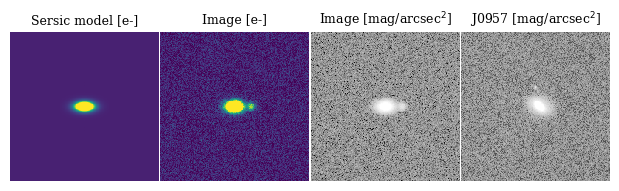

In [7]:
j0957_f = fits.open('/home/liza/work/data/sdss/frame-i-001473-3-0043.fits')
j0957 = j0957_f[0].data[170:370, 915:1115]
j0957_f.close()

fig, axs = plt.subplots(1, 4, figsize=(6,1.5))
axs[0].imshow(pristine, vmax=1000, vmin=-100)
axs[1].imshow(img, vmax=1000, vmin=-100)
axs[2].imshow(-2.5*np.log10(np.abs(img/pxscale_sdss**2))+ZP,     vmin=20, vmax=30, cmap='gray_r')
axs[3].imshow(-2.5*np.log10(np.abs(j0957/pxscale_sdss**2))+22.5, vmin=20, vmax=30, cmap='gray_r')
axs[0].set_title('Sersic model [e-]', size=9)
axs[1].set_title('Image [e-]', size=9)
axs[2].set_title(r'Image [mag/arcsec$^2$]', size=9)
axs[3].set_title(r'J0957 [mag/arcsec$^2$]', size=9)

for ax in axs: ax.axis('off')
plt.subplots_adjust(wspace=0.01)

## Test asymmetry functions

We want to compare different definitions of asymmetry and how they perform when varying 1) noise level, 2) PSF FWHM, 3) aperture size

In [11]:
a, a_center = get_asymmetry(img, ap_size=50, bg_size=50, a_type='cas', bg_corr='none')
print(a)

0.4816428802597193
